In [2]:
%reset -fs

In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

To-do:
- Load data
- Categorize pitches
- Categorize outcomes
- Establish features
- Train RF model for each pitch type

Concat all .csv files for 2021's regular season

In [4]:
columns = ['date', 't1', 'pitcher', 't2', 'batter', 'inning', 'result', 'pitch_type', 
           'mph', 'rpm', 'vbreak', 'up_down', 'hbreak', 'left_right', 'count']
df = pd.DataFrame(columns = columns)
# Reading in all csvs and appending to one dataframe
for month in range(4, 11):
    print(month)
    files = os.listdir(str(month) + '/')
    df_month = pd.concat([pd.read_csv(str(month) + '/' + file, index_col = 0) for file in files if file.endswith('.csv')], ignore_index = True)
    if len(df) == 0:
        df = df_month
    else:
        df = pd.concat([df, df_month], ignore_index = True)
    
            

4
5
6
7
8
9
10


Pitch types:
- 4-Seam Fastball
- Slider
- Sinker
- Changeup
- Curveball
- Cutter
- Knuckle Curve
- Splitter
- Fastball
- Slow Curve
- Eephus
- Knucle Ball

Groups:
- 4-Seam/Fastball
- Slider
- Sinker
- Changeup
- Curve/Knuckle Curve/Slow Curve
- Knuckle Ball/ Splitter
- Cutter

Result types:
- Ball
- Foul
- Called Strike
- Swinging Strike
- In play, out(s)
- In play, no out
- Ball in Dirt
- In play, run(s)
- Foul Tip
- Hit By Pitch
- Foul Bunt
- Missed Bunt
- Pitchout

Groups:
- Strikes
- Balls - Filter out
- Contact
- Fouls - Filter out

Very important -- make sure numeric values are read as numeric!

In [5]:
df['rpm'] = df['rpm'].apply(int)
df['vbreak'] = df['vbreak'].apply(int)
df['hbreak'] = df['hbreak'].apply(int)

In [6]:
df['left_right'].value_counts()

←    327578
→    260159
Name: left_right, dtype: int64

In [7]:
df['left_right'] = df['left_right'].apply(lambda x: x == '←')

Grouping results and pitch types

In [8]:
result_dict = {'Ball': 'Ball',
               'Foul': 'Foul',
               'Called Strike': 'Strike',
               'Swinging Strike': 'Strike',
               'In play, out(s)': 'Contact',
               'In play, no out': 'Contact',
               'Ball In Dirt': 'Ball',
               'In play, run(s)': 'Contact',
               'Foul Tip': 'Strike',
               'Hit By Pitch': 'Ball',
               'Foul Bunt': 'Strike',
               'Missed Bunt': 'Strike',
               'Pitchout': 'Ball'}

In [9]:
def group_pitches(x):
    if 'Fastball' in x:
        return 'Fastball'
    elif 'Curve' in x:
        return 'Curveball'
    elif ('Knuc' in x) or (x == 'Splitter'):
        return 'Splitter'
    else:
        return x


In [10]:
df['result'].value_counts()

Ball               201182
Foul               107570
Called Strike       99187
Swinging Strike     68763
In play, out(s)     67077
In play, no out     23025
Ball In Dirt        14730
In play, run(s)     13612
Foul Tip             5782
Hit By Pitch         1784
Foul Bunt            1302
Missed Bunt           311
Pitchout               25
Foul Pitchout           1
Name: result, dtype: int64

In [11]:
df['result'] = df['result'].map(result_dict)
df['pitch_type'] = df['pitch_type'].apply(group_pitches)

In [12]:
df['result'].value_counts()

Ball       217721
Strike     175345
Foul       107570
Contact    103714
Name: result, dtype: int64

Only keeping pitches that resulted in 'Strike' or 'Contact'

In [13]:
df = df.dropna()
df = df.loc[(df['result'] == 'Strike') | (df['result'] == 'Contact')]
codes, uniques = pd.factorize(df['result'])
df['result'] = codes

In [14]:

pitch_types = ['Fastball', 'Slider', 'Sinker', 'Changeup', 'Curveball', 'Splitter', 'Cutter']
#pitch_type = pitch_types[1]



Features:
- MPH
- RPM
- VBreak
- HBreak
- Break is Left

In [15]:
from joblib import dump

In [16]:
from sklearn.metrics import f1_score

In [93]:
def fit_score(X_train, X_test, y_train, y_test, pitch_type, model):

    model.fit(X_train, y_train)
    acc = cross_val_score(model, X_train, y_train, cv = 5)
    f1 = f1_score(y_test, model.predict(X_test))
    preds = model.predict_proba(X_test)
    
    #print(f'Acc: {acc.mean():.3f} | F1: {f1:.3f}')
    #print(f'Max: {preds[:,0].max():.3f} \n{X_test.iloc[np.argmax(preds[:,0])]}')
    return acc.mean(), f1

In [131]:
df.head()

,date,t1,pitcher,t2,batter,inning,result,pitch_type,mph,rpm,vbreak,up_down,hbreak,left_right,count
0,2021-4-23,Brewers,Kyle Hendricks,Cubs,Kolten Wong,1,0,Fastball,85.5,1866,22,↓,8,True,"(0, 0)"
1,2021-4-23,Brewers,Kyle Hendricks,Cubs,Kolten Wong,1,1,Fastball,85.9,1798,23,↓,8,True,"(0, 1)"
2,2021-4-23,Brewers,Kyle Hendricks,Cubs,Billy McKinney,1,0,Fastball,86.7,1968,21,↓,10,True,"(0, 0)"
3,2021-4-23,Brewers,Kyle Hendricks,Cubs,Billy McKinney,1,0,Fastball,86.1,1866,21,↓,8,True,"(0, 1)"
7,2021-4-23,Brewers,Kyle Hendricks,Cubs,Billy McKinney,1,0,Fastball,87.2,1890,20,↓,6,True,"(2, 2)"


In [141]:
df_dummies = pd.get_dummies(df, columns = ['pitch_type'])

In [146]:
df.head()

,date,t1,pitcher,t2,batter,inning,result,pitch_type,mph,rpm,vbreak,up_down,hbreak,left_right,count
0,2021-4-23,Brewers,Kyle Hendricks,Cubs,Kolten Wong,1,0,Fastball,85.5,1866,22,↓,8,True,"(0, 0)"
1,2021-4-23,Brewers,Kyle Hendricks,Cubs,Kolten Wong,1,1,Fastball,85.9,1798,23,↓,8,True,"(0, 1)"
2,2021-4-23,Brewers,Kyle Hendricks,Cubs,Billy McKinney,1,0,Fastball,86.7,1968,21,↓,10,True,"(0, 0)"
3,2021-4-23,Brewers,Kyle Hendricks,Cubs,Billy McKinney,1,0,Fastball,86.1,1866,21,↓,8,True,"(0, 1)"
7,2021-4-23,Brewers,Kyle Hendricks,Cubs,Billy McKinney,1,0,Fastball,87.2,1890,20,↓,6,True,"(2, 2)"


Fastball     1735
Sinker        107
Cutter         68
Curveball      49
Slider         31
Changeup       10
Name: pitch_type, dtype: int64

In [145]:
for max_depth in [7,8,9]:
    X = df[['mph', 'rpm', 'vbreak', 'hbreak', 'left_right']]
    y = df['result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    estimators = 128
    rf = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth, criterion = 'entropy',
                               class_weight = 'balanced') #{0:y_train.mean(),1:1-y_train.mean()})
    weights = 'balanced'
    rf.fit(X_train, y_train)
    scores = cross_val_score(rf, X_train, y_train, cv = 5)
    fifax = rf.predict_proba(X_test)[:,0]
    print(f'Depth {max_depth} | Weights {weights}')
    print(f'Acc: {scores.mean():.3f}')
    print(f'Mean: {fifax.mean():.3f}')
    print(f'Min: {fifax.min():.3f}')
    print(f'Max: {fifax.max():.3f}')
    print(f'F1 score: {f1_score(y_test, rf.predict(X_test)):.3f}')

Depth 7 | Weights balanced
Acc: 0.541
Mean: 0.502
Min: 0.168
Max: 0.751
F1 score: 0.480
Depth 8 | Weights balanced
Acc: 0.543
Mean: 0.502
Min: 0.136
Max: 0.770
F1 score: 0.478
Depth 9 | Weights balanced
Acc: 0.546
Mean: 0.503
Min: 0.095
Max: 0.791
F1 score: 0.476


Depth 3 | Weights custom
Acc: 0.5386186754633134
Mean: 0.501019885732919
Min: 0.42708463445444267
Max: 0.6073323135157587
F1 score: 0.46654125235151844
Depth 5 | Weights custom
Acc: 0.5357384476357419
Mean: 0.5014147522472726
Min: 0.23066175913960513
Max: 0.6733211318918977
F1 score: 0.48362082608007595
Depth 7 | Weights custom
Acc: 0.540674668812156
Mean: 0.5022430954702853
Min: 0.1373527355394725
Max: 0.7406122177991755
F1 score: 0.47964224006504724
Depth 9 | Weights custom
Acc: 0.5457811226183116
Mean: 0.5033356951422552
Min: 0.10845034549808664
Max: 0.8034860603931545
F1 score: 0.4763473177158385
Depth 11 | Weights custom
Acc: 0.5497453222606781
Mean: 0.5053064745183731
Min: 0.07368298512266325
Max: 0.8604298116538673
F1 score: 0.47294748753195587
Depth 13 | Weights custom
Acc: 0.5540275879369346
Mean: 0.5087369764463511
Min: 0.05589006302083314
Max: 0.8971897197894433
F1 score: 0.4706956207943281
Depth 15 | Weights custom
Acc: 0.5607197345215287
Mean: 0.5148353507503024
Min: 0.036582239820204074
Max: 0.9308125468300203
F1 score: 0.4612511261013821

Depth 3 | Weights balanced
Acc: 0.539
Mean: 0.501
Min: 0.429
Max: 0.628
F1 score: 0.469
Depth 5 | Weights balanced
Acc: 0.535
Mean: 0.501
Min: 0.262
Max: 0.686
F1 score: 0.482
Depth 7 | Weights balanced
Acc: 0.540
Mean: 0.502
Min: 0.136
Max: 0.747
F1 score: 0.481
Depth 9 | Weights balanced
Acc: 0.545
Mean: 0.503
Min: 0.113
Max: 0.805
F1 score: 0.478
Depth 11 | Weights balanced
Acc: 0.549
Mean: 0.505
Min: 0.076
Max: 0.872
F1 score: 0.475
Depth 13 | Weights balanced
Acc: 0.555
Mean: 0.509
Min: 0.049
Max: 0.909
F1 score: 0.469
Depth 15 | Weights balanced
Acc: 0.560
Mean: 0.515
Min: 0.022
Max: 0.936
F1 score: 0.463

In [94]:

depth_list = [3, 5, 7, 9, 11, 13, 15, 17, 25]

for pitch_type in pitch_types:

    df_filter = df.loc[df['pitch_type'] == pitch_type]
    X = df_filter[['mph', 'rpm', 'vbreak', 'hbreak', 'left_right']]
    y = df_filter['result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    results_df = pd.DataFrame(columns = ['depth', 'accuracy', 'f1', 'model'])
    for depth in depth_list:
        
        estimators = 128    
        rf = RandomForestClassifier(n_estimators = estimators, max_depth = depth, criterion = 'entropy',
                               class_weight = {0:y.mean(),1:1-y.mean()}, random_state = 22)
        results = fit_score(X_train, X_test, y_train, y_test, pitch_type, rf)
        results_arr = np.array(results)
        results_df.loc[len(results_df)] = [depth, results[0], results[1], 'rf']
        
    
    results_df.to_csv(pitch_type + '-results.csv')
    

In [104]:
pitch_types

['Fastball', 'Slider', 'Sinker', 'Changeup', 'Curveball', 'Splitter', 'Cutter']

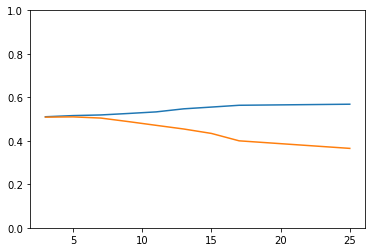

In [118]:
results_df = pd.read_csv(pitch_types[6] + '-results.csv', index_col = 0)
plt.plot(results_df['depth'], results_df['accuracy'])
plt.ylim(0, 1)
plt.plot(results_df['depth'], results_df['f1'])

In [171]:
# Training RF for each pitch type, then saving the file to disk
depth = 8
for pitch_type in pitch_types:
    df_filter = df.loc[df['pitch_type'] == pitch_type]
    X = df_filter[['mph', 'rpm', 'vbreak', 'hbreak', 'left_right']]
    y = df_filter['result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=22)
    estimators = 128
    max_depth = depth
    # Be sure to weight classes appropriately to improve F1
    rf = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth, criterion = 'entropy',
                               class_weight = 'balanced')
    #print(f'Estimators: {estimators}')
    #print(f'Max depth: {max_depth}')
    #print(f'Cross val score: {scores.mean()}')
    rf.fit(X_train, y_train)
    scores = cross_val_score(rf, X_train, y_train, cv = 5)
    print(f'Depth: {depth}')
    print(f'Mean: {rf.predict_proba(X_test)[:,0].mean():.3f}')
    print(f'Min: {rf.predict_proba(X_test)[:,0].min():.3f}')
    print(f'Max: {rf.predict_proba(X_test)[:,0].max():.3f}')
    print(f'F1 score: {f1_score(y_test, rf.predict(X_test)):.3f}')
    print(f'Random Forest val score for {pitch_type}: {rf.score(X_test, y_test):.3f}')
    print('---')
    dump(rf, pitch_type + '3.rf')

Depth: 8
Mean: 0.504
Min: 0.119
Max: 0.808
F1 score: 0.466
Random Forest val score for Fastball: 0.531
---
Depth: 8
Mean: 0.504
Min: 0.186
Max: 0.815
F1 score: 0.435
Random Forest val score for Slider: 0.508
---
Depth: 8
Mean: 0.501
Min: 0.370
Max: 0.768
F1 score: 0.515
Random Forest val score for Sinker: 0.525
---
Depth: 8
Mean: 0.502
Min: 0.276
Max: 0.902
F1 score: 0.486
Random Forest val score for Changeup: 0.518
---
Depth: 8
Mean: 0.506
Min: 0.271
Max: 0.850
F1 score: 0.411
Random Forest val score for Curveball: 0.535
---
Depth: 8
Mean: 0.516
Min: 0.244
Max: 0.817
F1 score: 0.395
Random Forest val score for Splitter: 0.539
---
Depth: 8
Mean: 0.507
Min: 0.312
Max: 0.898
F1 score: 0.505
Random Forest val score for Cutter: 0.503
---


Model Scores: (Max depth = 7)
- Fastball: .633
- Slider: 0.672
- Sinker 0.579
- Changeup 0.569
- Curve/Knuckle Curve/Slow Curve 0.683
- Knuckle Ball/ Splitter 0.623
- Cutter 0.614

Model V2 Scores (acc/F1): (Max depth = 11)
- Fastball: .603/.318
- Slider: 0.647/.226
- Sinker 0.552/.387
- Changeup 0.545/.414
- Curve/Knuckle Curve/Slow Curve 0.659/.190
- Knuckle Ball/ Splitter 0.605/.347
- Cutter 0.559/.346

Model V3 Scores (Max depth = 8, class balance)
- Fastball: .531/.466
- Slider: .508/.435
- Sinker .525/.515
- Changeup .518/.486
- Curve/Knuckle Curve/Slow Curve .535/.411
- Knuckle Ball/ Splitter .539/.395
- Cutter .503/.505




In [ ]:
from joblib import load

test_pitch = pitch_types[4]
rf = load(test_pitch + '3.rf')
df_test = df.loc[df.pitch_type == test_pitch]
X = df_test[['mph', 'rpm', 'vbreak', 'hbreak', 'left_right']]
preds = rf.predict_proba(X)[:,0]
df_test['test_fifax'] = preds


mpl_df = pd.DataFrame(columns = ['threshold', 'accuracy', 'recall', 'precision'])

for i in np.linspace(0.3, 0.7):
    def apply_decision(fin):
        if fin > i:
            return 0
        else:
            return 1
    df_test['pred'] = df_test['test_fifax'].apply(apply_decision)
    
    tp = len(df_test.loc[(df_test.pred == 0) & (df_test.result == 0)])
    fp = len(df_test.loc[(df_test.pred == 0) & (df_test.result == 1)])
    fn = len(df_test.loc[(df_test.pred == 1) & (df_test.result == 0)])
    accuracy = (df_test.pred == df_test.result).mean()
    recall = tp/(tp + fn)
    precision = tp/(tp + fp)
    #print(f'thresh: {i:.2f}, acc:{accuracy:.3f}, rec: {recall:.3f}, prec: {precision:.3f}')
    mpl_df.loc[len(mpl_df)] = [i, accuracy, recall, precision]


plt.plot(mpl_df.threshold, mpl_df.accuracy, label = 'acc')
plt.ylim(0, 1)
plt.plot(mpl_df.threshold, mpl_df.recall, label = 'recall')
plt.plot(mpl_df.threshold, mpl_df.precision, label = 'precision')
plt.legend()

In [ ]:
df.loc[df.pitch_type == 'Changeup'].sort_values(by = 'test_fifax', ascending = False).head(20)

In [ ]:
df.sort_values(by = 'test_fifax', ascending = False).head(2000).pitch_type.value_counts()